In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time
import numpy as np
import torch
import pyzed.sl as sl
import rerun as rr
import time
import kornia as K
import mediapy as media
import matplotlib.pyplot as plt

from ember.corners import compute_corner_map

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
rr.init("checkerboard.ipynb", spawn=True)
rr.connect()  # Connect to a remote viewer

def sl_image_to_np(sl_image):
    # BRGA to RGB
    image = sl_image.numpy()
    image = image[..., [2, 1, 0, 3]]
    return image

In [3]:
RECORDING_PATH = "C:/Users/DOMCE/OneDrive/Desktop/Personal Projects/embodied-perception/data/zed_recordings/HD720_SN33087127_15-44-16.svo2"

init_parameters = sl.InitParameters()
init_parameters.set_from_svo_file(RECORDING_PATH)

# Open the camera
zed_camera = sl.Camera()
camera_status = zed_camera.open(init_parameters)
if camera_status != sl.ERROR_CODE.SUCCESS: #Ensure the camera opened succesfully 
    print("Camera Open", camera_status, "Exit program.")
    exit(1)

runtime_param = sl.RuntimeParameters()


sl_image_left = sl.Mat()
sl_image_right = sl.Mat()
sl_depth = sl.Mat()

assert zed_camera.grab(runtime_param) == sl.ERROR_CODE.SUCCESS
# Retrieve frame data
frame_idx = zed_camera.get_svo_position()
# zed_camera.

zed_camera.retrieve_image(sl_image_left, sl.VIEW.LEFT)
zed_camera.retrieve_image(sl_image_right, sl.VIEW.RIGHT)
zed_camera.retrieve_measure(sl_depth, sl.MEASURE.DEPTH)  # Get the depth map

image_left=sl_image_to_np(sl_image_left)
image_right=sl_image_to_np(sl_image_right)
depth=sl_depth.numpy()

In [37]:
# Log frame data
rr.set_time_sequence("frame_idx", frame_idx)
rr.log("image_left", rr.Image(image_left))
rr.log("image_right", rr.Image(image_right))
rr.log("depth", rr.Image(depth))

for name, frame in [("image_left", image_left), ("image_right", image_right)]:
    # Convert to tensor
    frame = K.utils.image_to_tensor(frame, keepdim=False).float() / 255.0

    corner_map = compute_corner_map(frame)
    rr.log(f"{name}_corners", rr.Image(
        K.utils.tensor_to_image(corner_map, keepdim=False)
    ))

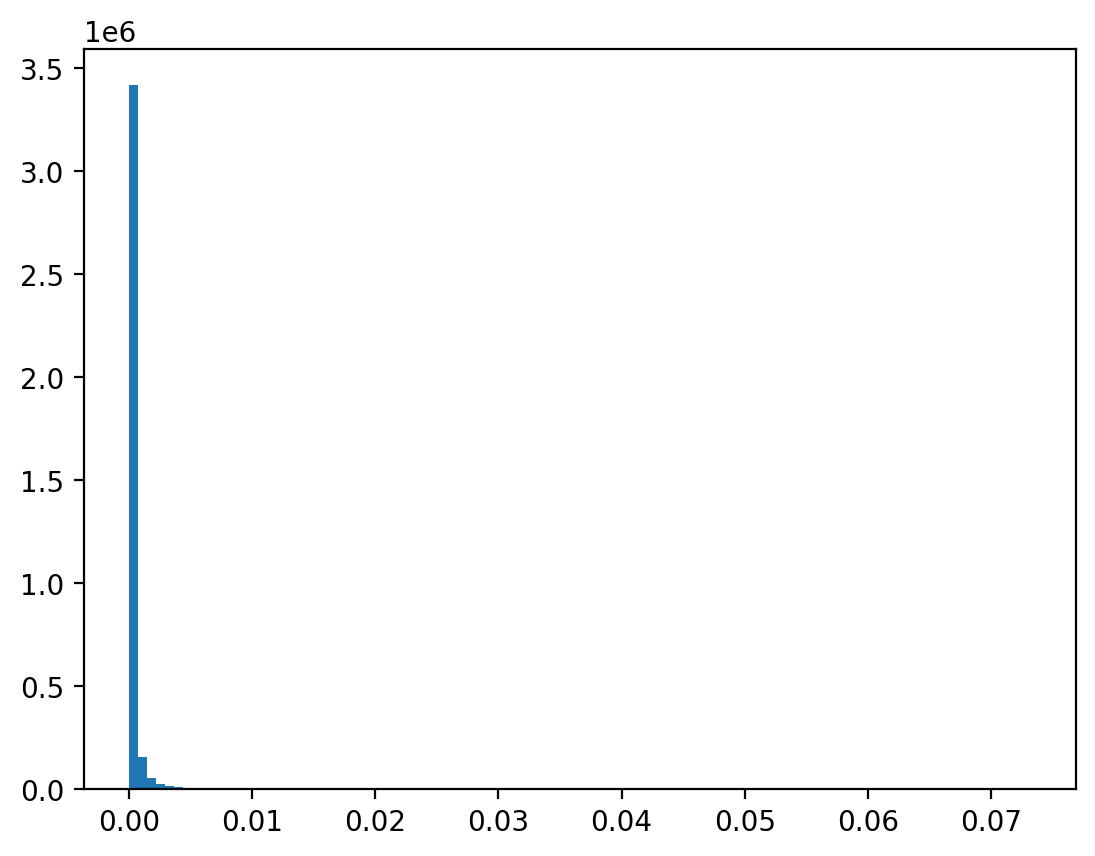

In [40]:
plt.hist(corner_map.flatten(), bins=100)
plt.show()

In [45]:

import ipywidgets as widgets
from IPython.display import display
from matplotlib.pylab import f

@widgets.interact(
    change = widgets.FloatSlider(
        value=0.5,  # Initial value
        min=0.0,    # Minimum value
        max=1.0,    # Maximum value
        step=0.01,  # Step size
        description='Float Parameter:',
        continuous_update=True
    )
)
def vis(change):
    corner_map = compute_corner_map(frame, change)

    image = corner_map[0, :3].moveaxis(0, -1).abs()
    image -= image.min()
    image /= image.max()

    fig = plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis("off")
    plt.show()


interactive(children=(FloatSlider(value=0.5, description='Float Parameter:', max=1.0, step=0.01), Output()), _…

In [47]:
frame.shape

torch.Size([1, 4, 720, 1280])

""

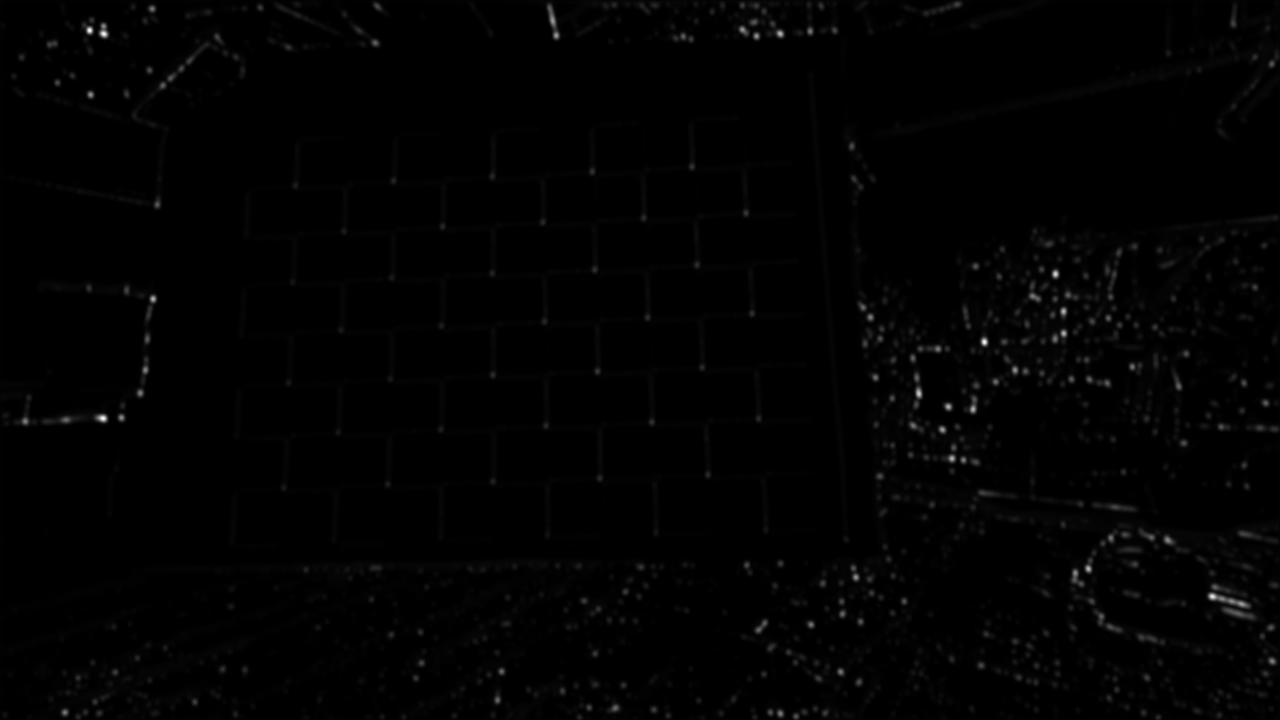

In [57]:
keynet = K.feature.KeyNet(pretrained=True)

corner_map = keynet(frame.mean(1, keepdim=True))
media.show_image(corner_map.detach().cpu().squeeze())

In [ ]:
media.show_image(corner_map.detach().cpu().squeeze())